# Real Estate Transactions Analysis

## Feature Information

| Name                  | Description                                                                                              | Primary Key | Size | Datatype | Range of Values | Language |
|-----------------------|----------------------------------------------------------------------------------------------------------|-------------|------|----------|-----------------|----------|
| `property_sub_type_en`| Sub type of the property (e.g., apartment, shop, office, etc.)                                           | No          | 100  | nvarchar |                 | English  |
| `property_usage_ar`   | Property use based on zoning authority's regulations in Arabic                                           | No          | 100  | nvarchar |                 | Arabic   |
| `property_usage_en`   | Property use based on zoning authority's regulations                                                     | No          | 100  | nvarchar |                 | English  |
| `reg_type_id`         | Type of registration (off-plan or existing properties)                                                   | No          | 1    | numeric  |                 | English  |
| `reg_type_ar`         | Type of registration in Arabic (off-plan or existing properties)                                         | No          | 100  | nvarchar |                 | Arabic   |
| `reg_type_en`         | Type of registration (off-plan or existing properties)                                                   | No          | 100  | nvarchar |                 | English  |
| `area_id`             | Area (community) ID                                                                                      | No          | 10   | numeric  |                 | English  |
| `area_name_ar`        | Community name in Arabic as per Dubai Municipality                                                       | No          | 200  | nvarchar |                 | Arabic   |
| `area_name_en`        | Community name in English as per Dubai Municipality                                                      | No          | 200  | nvarchar |                 | English  |
| `transaction_id`      | A unique ID of the transaction                                                                           | Yes         | 100  | nvarchar |                 | English  |
| `procedure_id`        | Number generated through the system                                                                      | No          | 3    | numeric  |                 | English  |
| `trans_group_id`      | The unique ID of transaction group                                                                       | No          | 3    | numeric  |                 | English  |
| `trans_group_ar`      | High level group type of the transaction in Arabic (Sales, Mortgages, Gifts)                             | No          | 200  | nvarchar |                 | Arabic   |
| `trans_group_en`      | High level group type of the transaction (Sales, Mortgages, Gifts)                                       | No          | 200  | nvarchar |                 | English  |
| `procedure_name_en`   | Sub type of the transaction (pre-registration sale, delayed sale, etc.)                                  | No          | 200  | nvarchar |                 | English  |
| `instance_date`       | Transaction registration date                                                                            | No          | 10   | date     | DD-MM-YYYY      | English  |
| `project_number`      | Developer's project number                                                                               | No          | 30   | numeric  |                 | English  |
| `project_name_ar`     | Developer's project Arabic name                                                                          | No          | 200  | nvarchar |                 | Arabic   |
| `project_name_en`     | Developer's project English name                                                                         | No          | 200  | nvarchar |                 | English  |
| `master_project_en`   | Master developer name in Arabic                                                                          | No          | 200  | nvarchar |                 | English  |
| `master_project_ar`   | Master developer name in English                                                                         | No          | 200  | nvarchar |                 | Arabic   |
| `nearest_landmark_ar` | Nearest landmark to the property in Arabic                                                               | No          | 200  | nvarchar |                 | Arabic   |
| `nearest_landmark_en` | Nearest landmark to the property in English                                                              | No          | 200  | nvarchar |                 | English  |
| `nearest_metro_ar`    | Nearest metro station to the property in Arabic                                                          | No          | 200  | nvarchar |                 | Arabic   |
| `nearest_metro_en`    | Nearest metro station to the property in English                                                         | No          | 200  | nvarchar |                 | English  |
| `nearest_mall_ar`     | Nearest mall to the property in Arabic                                                                   | No          | 202  | nvarchar |                 | Arabic   |
| `nearest_mall_en`     | Nearest mall to the property in English                                                                  | No          | 203  | nvarchar |                 | English  |
| `rooms_ar`            | Number of rooms in Arabic                                                                                | No          | 200  | nvarchar |                 | Arabic   |
| `rooms_en`            | Number of rooms in English                                                                               | No          | 200  | nvarchar |                 | English  |
| `has_parking`         | Does the unit have parking? (0=No, 1=Yes)                                                                | No          | 1    | numeric  |                 | English  |
| `procedure_area`      | The area (size) in square meters                                                                         | No          | 18   | numeric  |                 | English  |
| `actual_worth`        | Property price in the transaction                                                                        | No          | 20   | numeric  |                 | English  |
| `meter_sale_price`    | Meter price in the transaction                                                                           | No          | 18   | numeric  |                 | English  |
| `rent_value`          | Mortgage value in lease-to-own procedures                                                               | No          | 20   | numeric  |                 | English  |
| `meter_rent_price`    | Mortgage price per meter in lease-to-own procedures                                                      | No          | 20   | numeric  |                 | English  |
| `no_of_parties_role_1`| Number of transaction's parties with first role (seller, mortgagor, etc.)                                | No          | 3    | numeric  |                 | English  |
| `no_of_parties_role_2`| Number of transaction's parties of second role (buyer, mortgagee, etc.)                                  | No          | 3    | numeric  |                 | English  |
| `no_of_parties_role_3`| Number of transaction's parties of third role (lessee, usufructor, etc.)                                 | No          | 3    | numeric  |                 | English  |
| `building_name_ar`    | Building name in Arabic given by the developer                                                           | No          | 200  | nvarchar |                 | Arabic   |
| `building_name_en`    | Building name in English given by the developer                                                          | No          | 200  | nvarchar |                 | English  |
| `procedure_name_ar`   | Sub type of the transaction in Arabic                                                                    | No          | 200  | nvarchar |                 | Arabic   |
| `property_type_id`    | Number generated through the system                                                                      | No          | 4    | numeric  |                 | English  |
| `property_type_ar`    | Main type of the property in Arabic (land, building, villa or unit)                                      | No          | 50   | nvarchar |                 | Arabic   |
| `property_type_en`    | Main type of the property (land, building, villa or unit)                                                | No          | 50   | nvarchar |                 | English  |
| `property_sub_type_id`| PROPERTY_SUB_TYPE_ID                                                                                     | No          | 10   | numeric  |                 | English  |
| `property_sub_type_ar`| Sub type of the property in Arabic (e.g., apartment, shop, office, etc.)                                 | No          | 100  | nvarchar |                 | Arabic   |

## Import Libraries and Load Dataset

In [578]:
# Install necessary libraries
# !pip install missingno
# !pip install squarify
# !pip install xgboost

# Import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

%matplotlib inline

In [579]:
# ---------------------------------------------
# Environment Setup: SageMaker vs Local
# ---------------------------------------------

# Uncomment these lines if running inside a SageMaker notebook
# import sagemaker
# import boto3
# from sagemaker import Session

# sagemaker_session = sagemaker.Session()
# region = boto3.Session().region_name
# role = sagemaker.get_execution_role()

# S3 bucket and path to the raw dataset
bucket = 'dld-transactions-project'
raw_data_key = 'dld_transactions_data/Transactions.csv'
raw_data_location = f's3://{bucket}/{raw_data_key}'

# ---------------------------------------------
# Load the Dataset
# ---------------------------------------------

# Option 1: Load data from S3 (when running in SageMaker)
if os.environ.get("SAGEMAKER_ENV"):
    print("Running in SageMaker. Loading from S3...")
    df = pd.read_csv(raw_data_location)

# Option 2: Load data from local CSV (when running locally)
else:
    print("Running locally. Loading from local file...")
    raw_data_key = 'data/Transactions.csv'
    df = pd.read_csv(raw_data_key)

Running locally. Loading from local file...


## Data Exploration and Cleaning

### Explore the descriptive statistics of the variables

In [580]:
# Explore the descriptive statistics and information of the dataset
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Dataset Information:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe(include='all'))

print("\nColumns in the dataset:")
print(df.columns)

print("\nShape of the dataset:")
print(df.shape)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512843 entries, 0 to 1512842
Data columns (total 46 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   transaction_id        1512843 non-null  object 
 1   procedure_id          1512843 non-null  int64  
 2   trans_group_id        1512843 non-null  int64  
 3   trans_group_ar        1512843 non-null  object 
 4   trans_group_en        1512843 non-null  object 
 5   procedure_name_ar     1512843 non-null  object 
 6   procedure_name_en     1512843 non-null  object 
 7   instance_date         1512843 non-null  object 
 8   property_type_id      1512843 non-null  int64  
 9   property_type_ar      1512843 non-null  object 
 10  property_type_en      1512843 non-null  object 
 11  property_sub_type_id  1195557 non-null  float64
 12  property_sub_type_ar  1195557 non-null  object 
 13  property_sub_type_en  1195557 non-null  object 
 14  property_usag

### Determine the variables of interest

In [581]:
# Drop duplicate low-information, ID columns and columns in Arabic

columns_to_drop = df.columns[
    df.columns.str.endswith(('_ar', '_id'))
].tolist() + [
    'project_number',       # project ID
    'no_of_parties_role_1', # irrelevant
    'no_of_parties_role_2', # irrelevant
    'no_of_parties_role_3', # irrelevant
    'property_type_en',     # redundant — sub-type is more descriptive
]

data = df.drop(columns=columns_to_drop).copy()

### Visualizing Numeric Correlations

<Axes: >

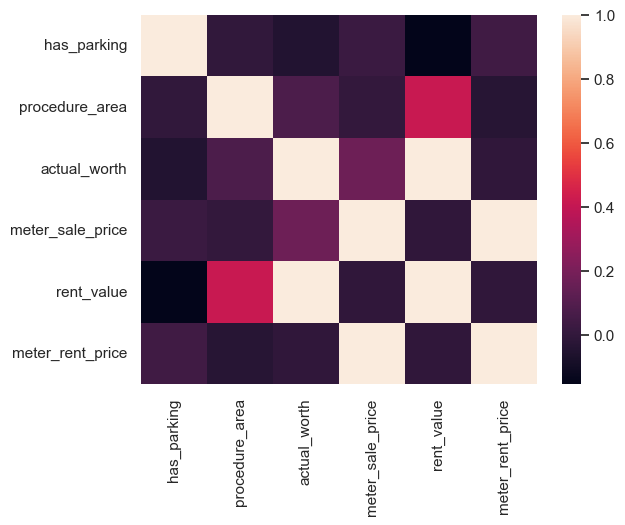

In [582]:
# calculate the correlation matrix on the numeric columns
corr = data.corr(numeric_only=True)

# plot the heatmap
sns.heatmap(corr)

### Normalize Categorical Feature Labels and Format Dates

In [583]:
# Convert 'instance_date' column to datetime
data['instance_date'] = pd.to_datetime(data['instance_date'], format='%d-%m-%Y', errors='coerce')

# Drop rows with invalid dates
data = data.dropna(subset=['instance_date'])

In [584]:
# Convert object columns to lowercase and replace spaces with underscores
object_cols = data.select_dtypes(include=['object']).columns

# Strip leading/trailing spaces, convert to lowercase, then replace internal spaces with underscores
data[object_cols] = data[object_cols].apply(lambda x: x.str.strip().str.lower().str.replace(' ', '_', regex=False))

### Analyze Transaction Categories and Exclude Non-Sale Records
Analyze Transaction Category Distribution with `trans_group_en` feature

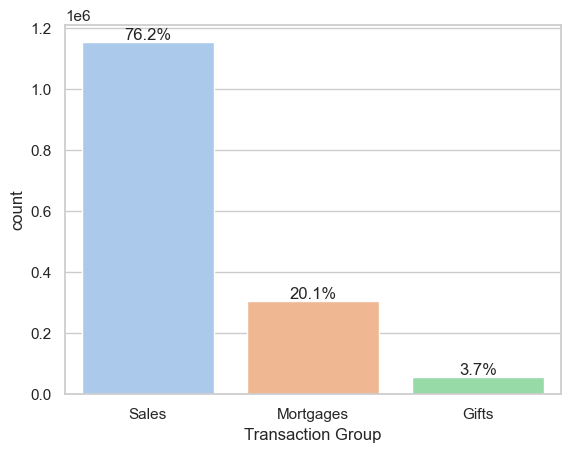

In [585]:
ax = sns.countplot(data=df, x='trans_group_en', 
                   order=df['trans_group_en'].value_counts().index,
                   palette='pastel',
                   hue='trans_group_en')

total = len(df)
for container in ax.containers:
    labels = [f'{(v.get_height() / total * 100):.1f}%' for v in container]
    ax.bar_label(container, labels=labels)

ax.set_xlabel('Transaction Group')
plt.show()


**Observation**: The dominance of sales suggests that our price modeling will primarily learn from sale transactions. Mortgages might not directly factor into a pricing model (they often represent loan registrations), and gift transactions may not reflect market value at all (often listed at nominal or zero price).

In [586]:
# Remove observations of transaction type 'gifts' since they are irrelevant
data = data[data['trans_group_en'] != 'gifts']

### Analyze Transaction Types and Retain Ownership-Related Procedures
Analyze Transaction Type Distribution with `procedure_name_en` feature

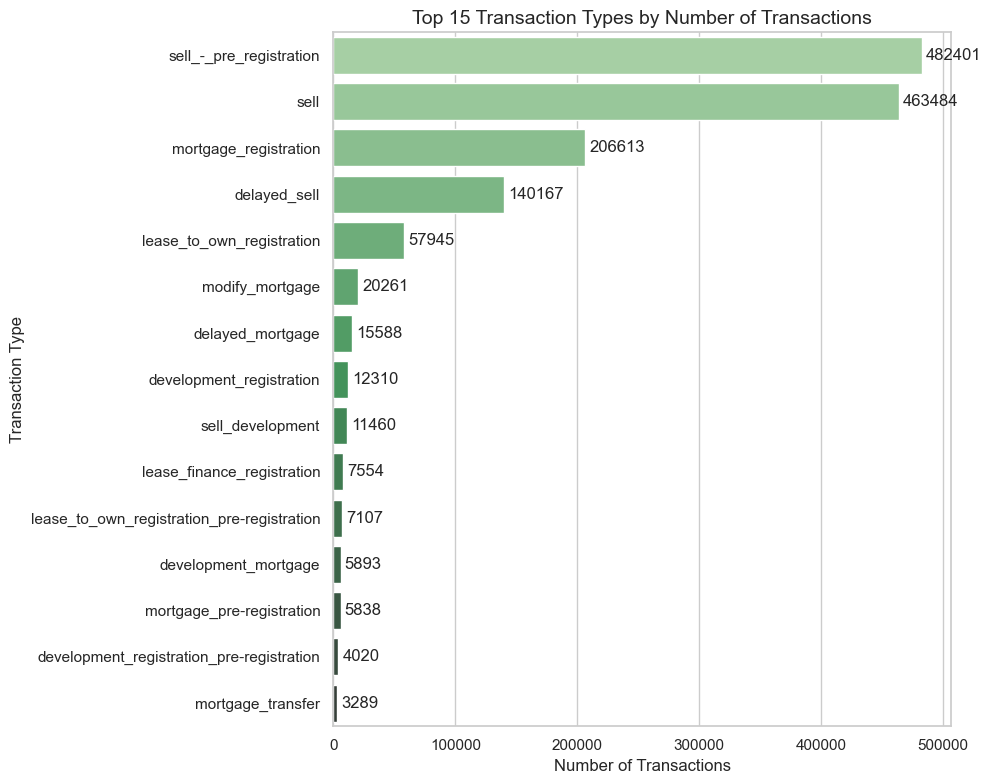

In [587]:
# Count transactions per transaction type
transaction_type_counts = data['procedure_name_en'].value_counts().head(15)  # Top 15 transaction types

# Set plot style
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x=transaction_type_counts.values, 
    y=transaction_type_counts.index, 
    palette="Greens_d",
    hue=transaction_type_counts.index
)

# Add bar labels
for container in ax.containers: # annotate bars with count
    ax.bar_label(container,fmt='%d', label_type='edge', padding=3)  

plt.title("Top 15 Transaction Types by Number of Transactions", fontsize=14)
plt.xlabel("Number of Transactions")
plt.ylabel("Transaction Type")
plt.tight_layout()
plt.show()

Observations:

- `Sell_-_pre_registration` and `Sell` dominate the landscape, accounting for over 945,885 transactions combined, highlighting the strong market for both off-plan and completed property sales.

- `Mortgage_registration` follows with ~207,000 records, reflecting the significant role of bank financing in property acquisition.

- `Delayed_sell` and `Lease_to_own_registration` also appear prominently, indicating some flexibility in transaction timing and ownership models.

The rest of the procedures (like development and mortgage-related processes) are an order of magnitude less frequent, suggesting they serve more niche or administrative purposes.

In [588]:
# Keep only transaction procedures that reflect an actual sale or transfer of ownership.
# This includes direct sales and lease-to-own agreements.

# Filter dataset to keep only sales-related records
data = data[data['procedure_name_en'].isin([
    'sell',
    'sell_-_pre_registration',
    'delayed_sell',
    'sell_development',
    'lease_to_own_registration',
    'lease_to_own_registration_pre-registration'
])]

### Analyze Geographical Distribution
Analyze Geographical Distribution with `master_project_en` feature


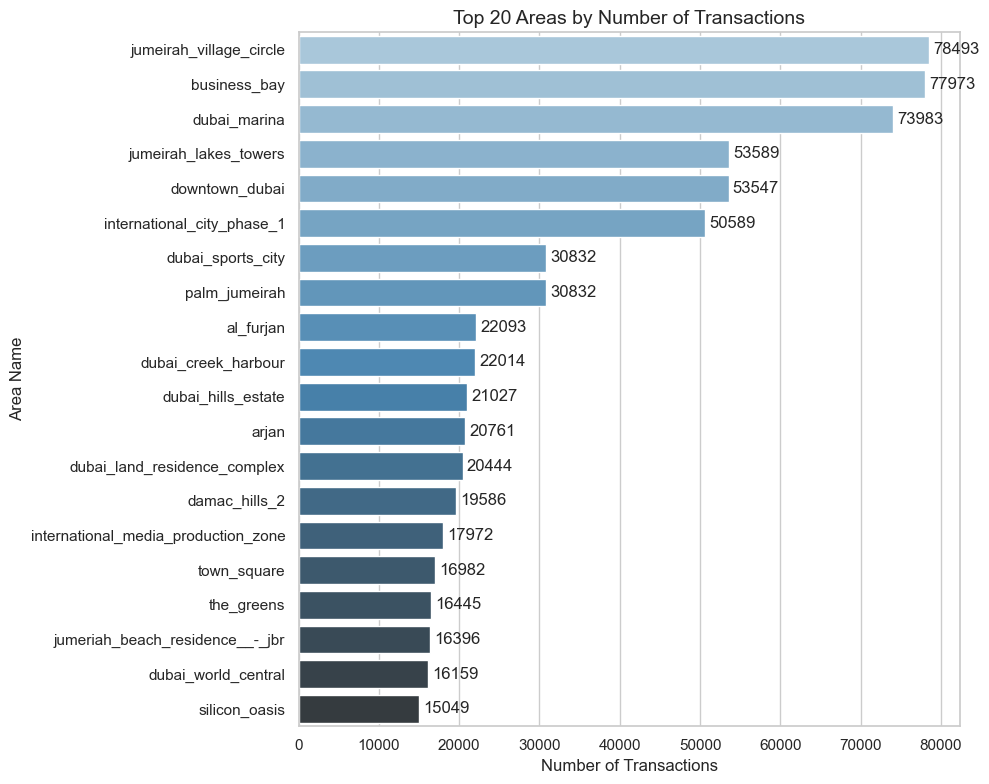

In [589]:
# Count transactions per area
area_counts = data['master_project_en'].value_counts().head(20)  # Top 20 areas

# Set plot style
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")

# Horizontal bar chart
ax = sns.barplot(
    x=area_counts.values, 
    y=area_counts.index, 
    palette="Blues_d",
    hue=area_counts.index
)

# Add bar labels
for container in ax.containers: # annotate bars with counts
    ax.bar_label(container,fmt='%d', label_type='edge', padding=3)  

plt.title("Top 20 Areas by Number of Transactions", fontsize=14)
plt.xlabel("Number of Transactions")
plt.ylabel("Area Name")
plt.tight_layout()
plt.show()

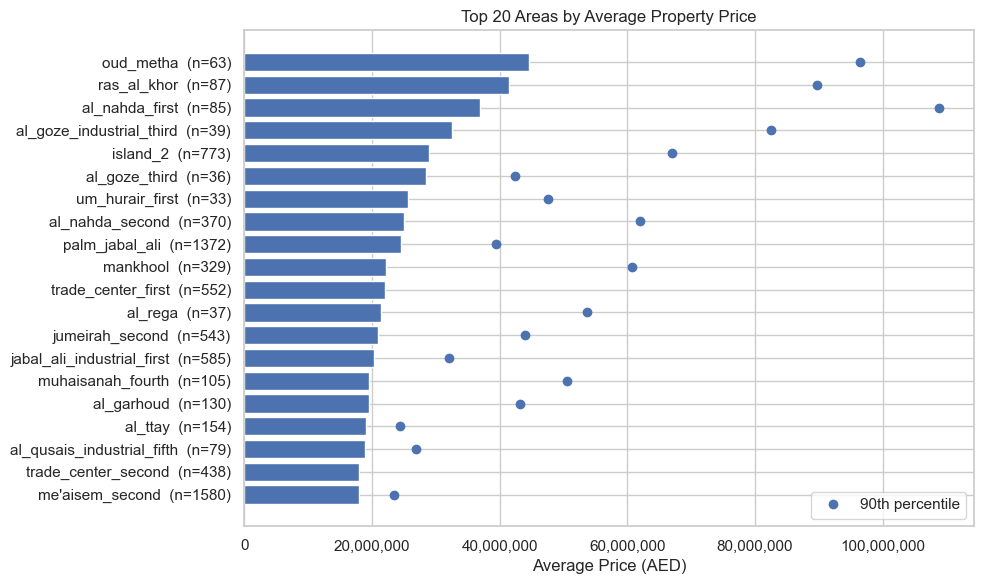

In [590]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# --- CONFIG ---
AREA_COL = "area_name_en"
PRICE_COL = "actual_worth"   # in AED (not log). If yours is log1p, replace with np.expm1(...)
TOP_K = 20
MIN_SAMPLES_PER_AREA = 30    # tweak to your dataset size

# 1) Aggregate area stats
area_stats = (
    data.groupby(AREA_COL)[PRICE_COL]
        .agg(mean_price="mean", median_price="median", n="count", p90=lambda s: s.quantile(0.90))
        .reset_index()
)

# 2) Keep areas with enough samples
area_stats = area_stats[area_stats["n"] >= MIN_SAMPLES_PER_AREA]

# 3) Take top-K by mean price
top = area_stats.sort_values("mean_price", ascending=False).head(TOP_K)

# 4) Horizontal bar chart (mean with 90th percentile as context)
plt.figure(figsize=(10, 6))
ypos = np.arange(len(top))

# Bars = mean price
plt.barh(ypos, top["mean_price"], align="center")

# Optional: overlay markers for 90th percentile to show spread
plt.plot(top["p90"], ypos, "o", label="90th percentile")

# Y labels: area name (with count)
labels = [f"{a}  (n={n})" for a, n in zip(top[AREA_COL], top["n"])]
plt.yticks(ypos, labels)
plt.gca().invert_yaxis()

# Currency formatting
plt.gca().xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

plt.xlabel("Average Price (AED)")
plt.title(f"Top {TOP_K} Areas by Average Property Price")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Filter Property Types and Standardize Room Labels

In [591]:
# Analyze property_sub_type_en feature
print(data['property_sub_type_en'].value_counts())

property_sub_type_en
flat                  776436
villa                  95836
office                 51346
hotel_apartment        23385
hotel_rooms            13145
shop                   12264
workshop                 426
stacked_townhouses       349
store                    295
building                  77
clinic                    56
warehouse                 38
show_rooms                35
hotel                     12
gymnasium                  8
sized_partition            7
parking                    4
unit                       1
Name: count, dtype: int64


In [592]:
# Remain only observations of specific property_sub_type_en
data = data[data['property_sub_type_en'].isin(
    ['flat', 
     'villa', 
     'hotel_apartment', 
     'hotel_rooms', 
     'stacked_townhouses'])]

data.groupby('property_sub_type_en').size()

property_sub_type_en
flat                  776436
hotel_apartment        23385
hotel_rooms            13145
stacked_townhouses       349
villa                  95836
dtype: int64

In [593]:
# Analyze rooms_en feature
data['rooms_en'].value_counts()

rooms_en
1_b/r          335842
2_b/r          224447
studio         183876
3_b/r          120087
4_b/r           38134
5_b/r            3968
penthouse        1128
single_room       682
6_b/r             266
7_b/r              45
shop               30
8_b/r               3
office              2
9_b/r               1
Name: count, dtype: int64

In [594]:
# Exclude properties of type 'office', 'shop' from dataset

data = data[~data['rooms_en'].isin(['office', 'shop'])]

In [595]:
# Replace b/r with bedroom in 'rooms_en' feature

data['rooms_en'] = data['rooms_en'].str.replace('b/r', 'bedroom')

In [596]:
print("Shape after filtering:", data.shape)
print(data['property_sub_type_en'].value_counts())

Shape after filtering: (909119, 20)
property_sub_type_en
flat                  776404
villa                  95836
hotel_apartment        23385
hotel_rooms            13145
stacked_townhouses       349
Name: count, dtype: int64


### Numerical Data Histogram

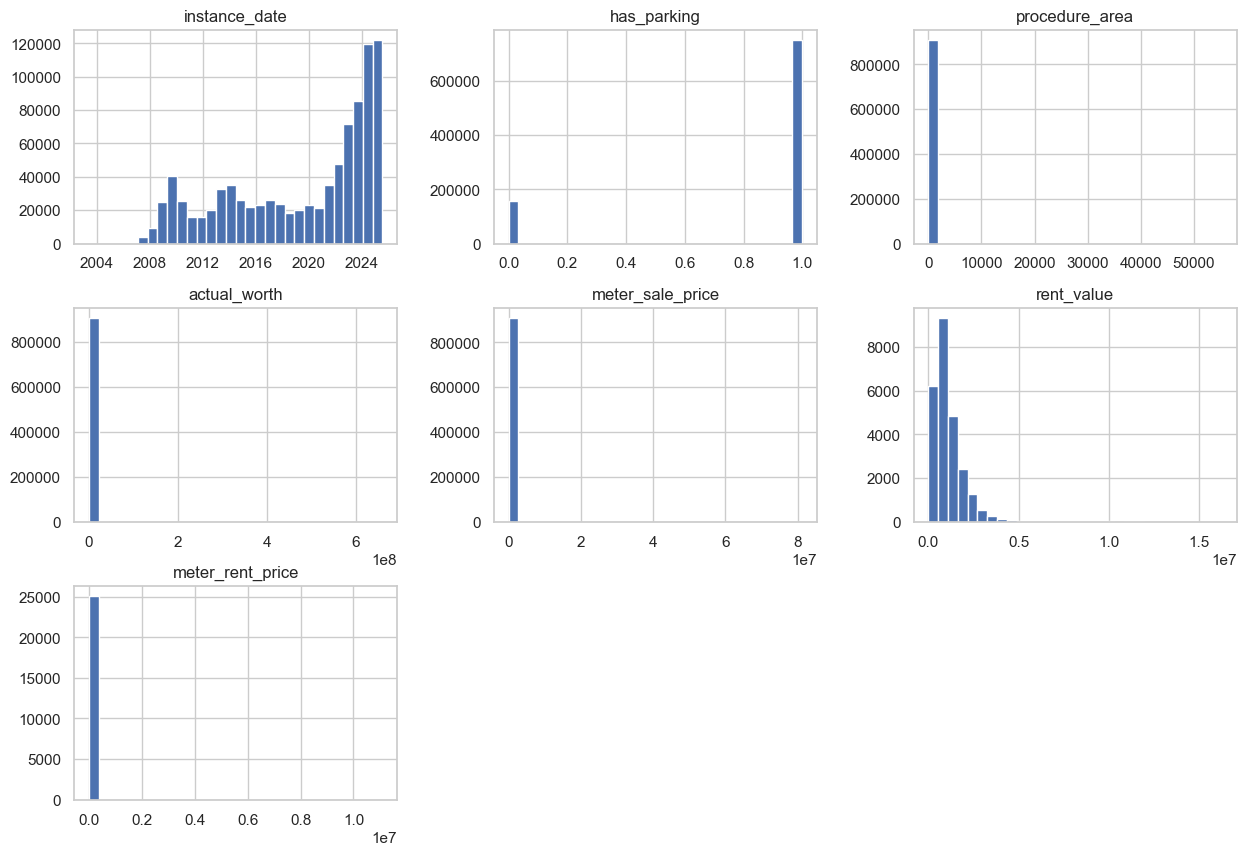

In [597]:
data.hist(bins=30, figsize=(15, 10))
plt.show()

### Handle hard errors and outliers

In [598]:
data[['actual_worth', 'procedure_area']].agg(['min', 'max', 'mean', 'std'])

,actual_worth,procedure_area
min,1.000,0.010
max,659741940.000,55362.940
mean,1715493.348,112.504
std,2960380.300,123.247


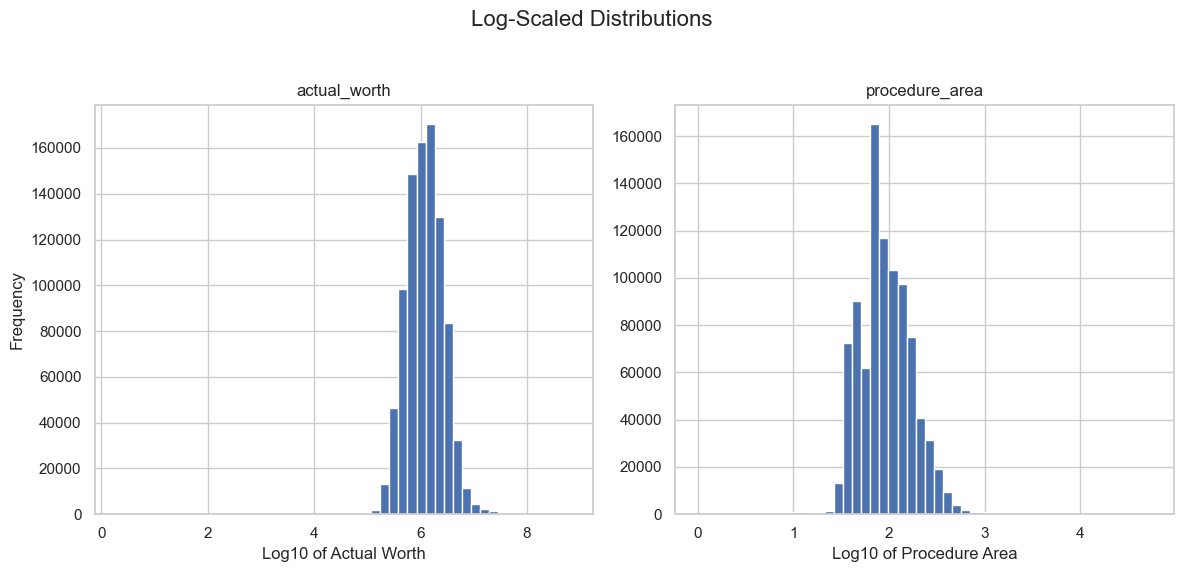

In [599]:
data_log = data.copy()
data_log['actual_worth'] = np.log10(data_log['actual_worth'] + 1)
data_log['procedure_area'] = np.log10(data_log['procedure_area'] + 1)

# Plot histograms and get axes
axes = data_log[['actual_worth', 'procedure_area']].hist(
    bins=50, figsize=(12, 6), layout=(1, 2)
)

# Add titles and axis labels
plt.suptitle("Log-Scaled Distributions", fontsize=16)

axes = axes.flatten()
axes[0].set_xlabel("Log10 of Actual Worth")
axes[0].set_ylabel("Frequency")
axes[1].set_xlabel("Log10 of Procedure Area")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()


Observation:
- The log-scaled distributions of actual_worth and procedure_area show tight peaks, but with heavy skewness and long tails.

- This indicates the presence of extreme outliers (e.g., very large worth or area) that distort the distribution.

- The data also contains unnaturally small or large values likely due to input errors or data quality issues.



**Remove data points with extreme values to focus on the bulk of the market**

In [600]:
# Determine outlier thresholds

high_area_thr = data['procedure_area'].quantile(0.999)
low_area_thr = data['procedure_area'].quantile(0.001)
high_price_thr = data['meter_sale_price'].quantile(0.999)
low_price_thr = data['meter_sale_price'].quantile(0.001)

In [601]:
# Identify outlier records
large_area_idx = data[data['procedure_area'] > high_area_thr].index
tiny_area_idx  = data[data['procedure_area'] < low_area_thr].index
high_price_idx = data[data['meter_sale_price'] > high_price_thr].index
low_price_idx  = data[data['meter_sale_price'] < low_price_thr].index
print(f"{len(large_area_idx)} records with area > {high_area_thr:.2f} m²")
print(f"{len(tiny_area_idx)} records with area < {low_area_thr:.2f} m²")
print(f"{len(low_price_idx)} records with price/m² < {low_price_thr:.2f} AED")
print(f"{len(high_price_idx)} records with price/m² > {high_price_thr:.2f} AED")

910 records with area > 971.51 m²
908 records with area < 7.86 m²
910 records with price/m² < 1247.35 AED
910 records with price/m² > 90991.89 AED


In [602]:
# Combine all outlier indices
outlier_indices = large_area_idx.union(tiny_area_idx).union(low_price_idx).union(high_price_idx)
print(f"Total outlier records to drop: {len(outlier_indices)}")

# Drop all outliers
new_data = data.drop(index=outlier_indices).reset_index(drop=True)

Total outlier records to drop: 3219


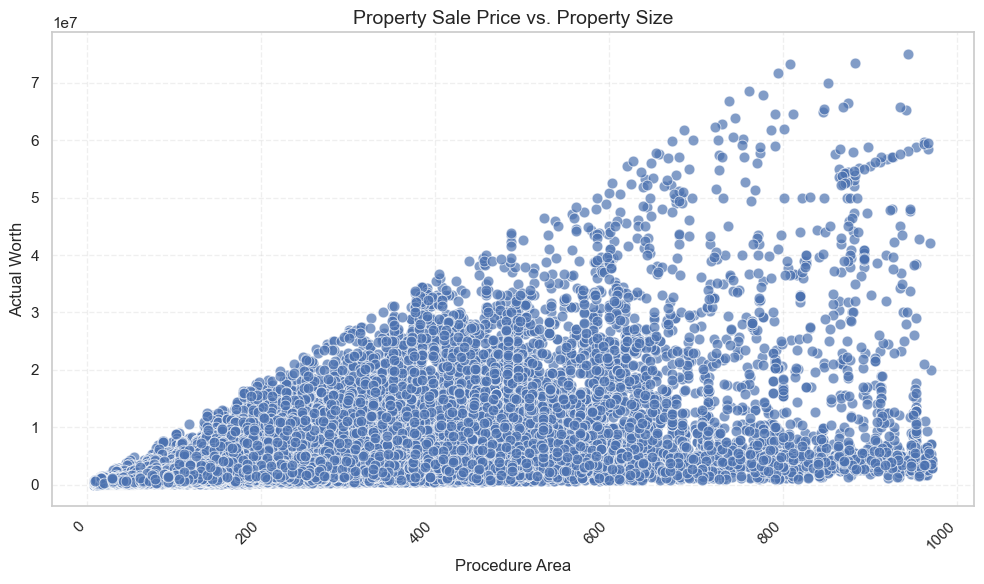

In [603]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=new_data,
    x='procedure_area',
    y='actual_worth',
    alpha=0.7,
    edgecolor='w',
    s=60
)

plt.title('Property Sale Price vs. Property Size', fontsize=14)
plt.xlabel('Procedure Area', fontsize=12)
plt.ylabel('Actual Worth', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


🔍 **Observations**:
- Strong base correlation: There's a clear upward trend — larger procedure_area generally leads to higher actual_worth.

- High variance in large areas: Above ~1000 area units, actual_worth varies widely — likely due to differences in location, condition, or room count.

- Few extreme values: A few points exceed 100 million, which may be luxury or outlier properties worth further review.


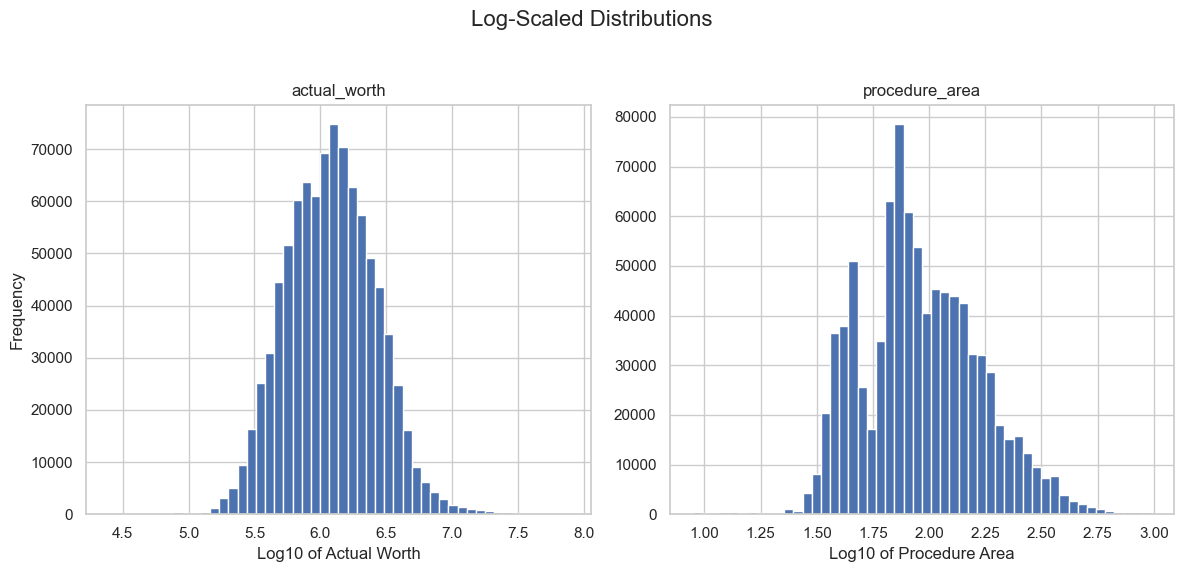

In [604]:
data_log = new_data.copy()
data_log['actual_worth'] = np.log10(data_log['actual_worth'] + 1)
data_log['procedure_area'] = np.log10(data_log['procedure_area'] + 1)

# Plot histograms and get axes
axes = data_log[['actual_worth', 'procedure_area']].hist(
    bins=50, figsize=(12, 6), layout=(1, 2)
)

# Add titles and axis labels
plt.suptitle("Log-Scaled Distributions", fontsize=16)

axes = axes.flatten()
axes[0].set_xlabel("Log10 of Actual Worth")
axes[0].set_ylabel("Frequency")
axes[1].set_xlabel("Log10 of Procedure Area")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()


Observation:
- The distributions have smoother, more symmetrical bell-shaped curves.
- The long tails are significantly reduced, confirming removal of extreme low/high anomalies.
- This results in a dataset that is more statistically robust, with values more centered around realistic ranges.



## Handling Missing Values


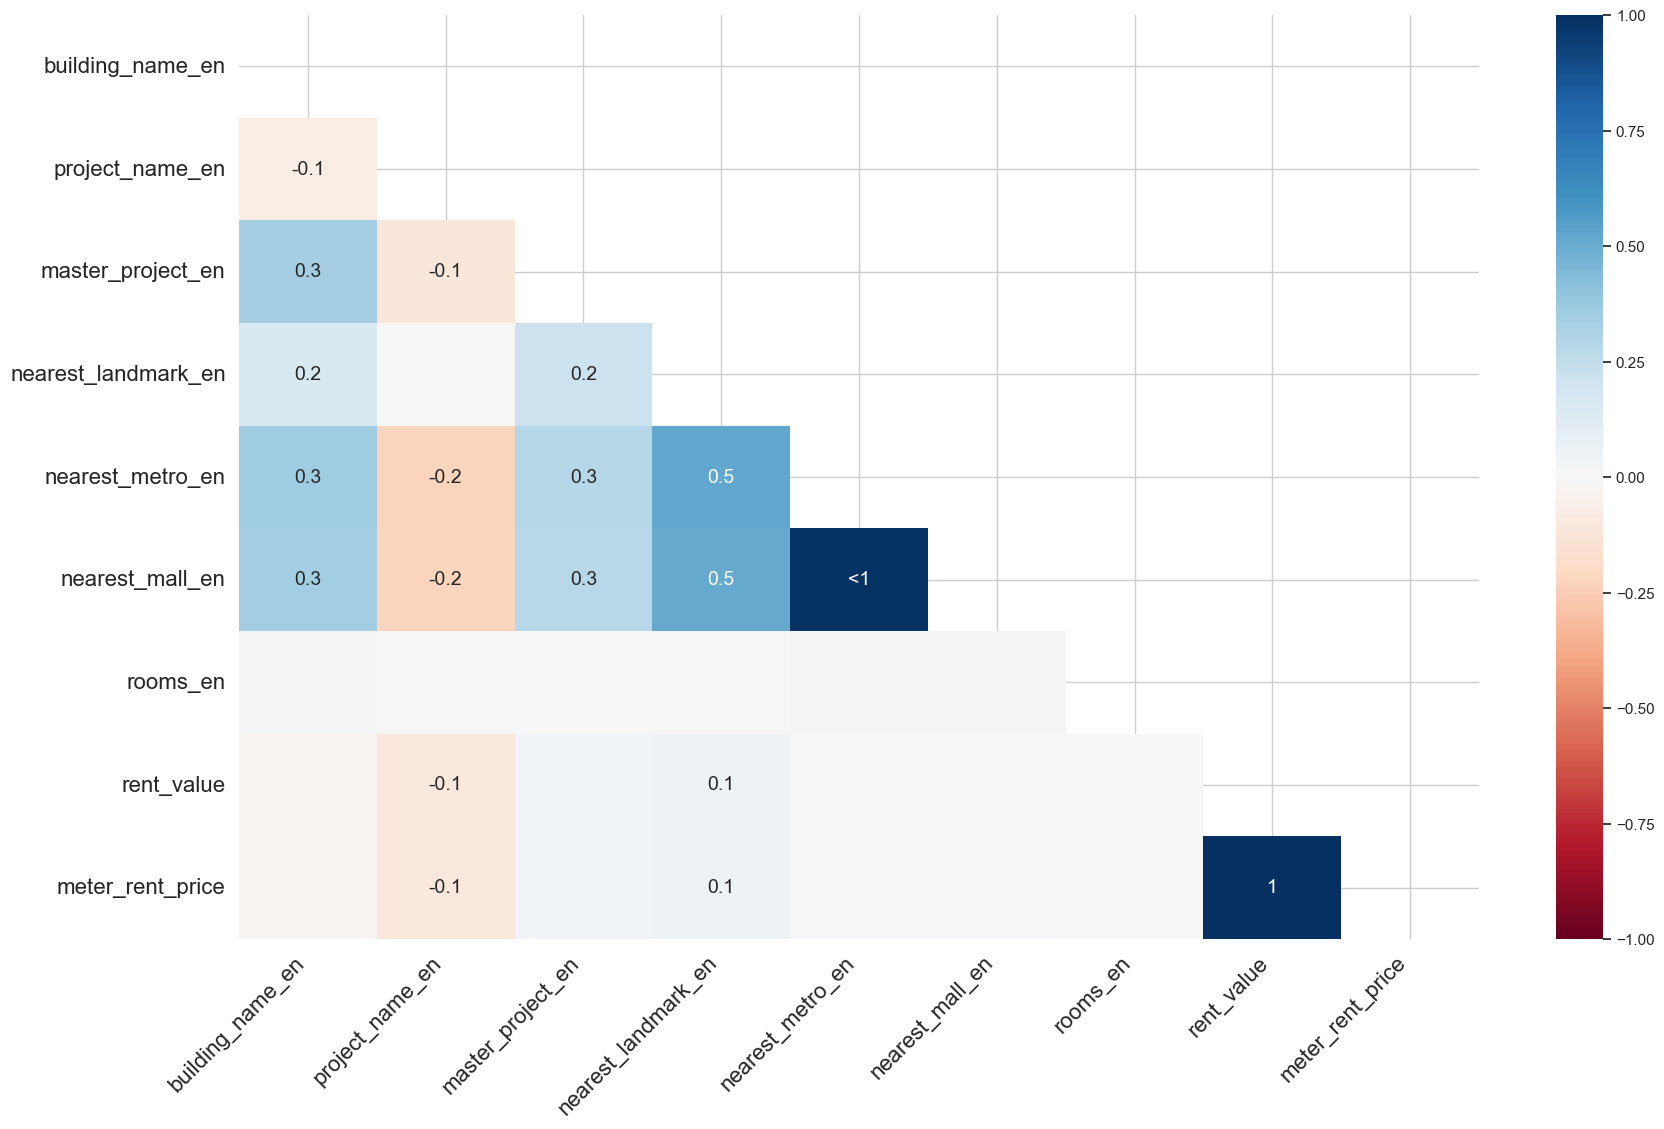

In [605]:
msno.heatmap(new_data)  # Heatmap visualization to check the correlation between missing values

plt.show()

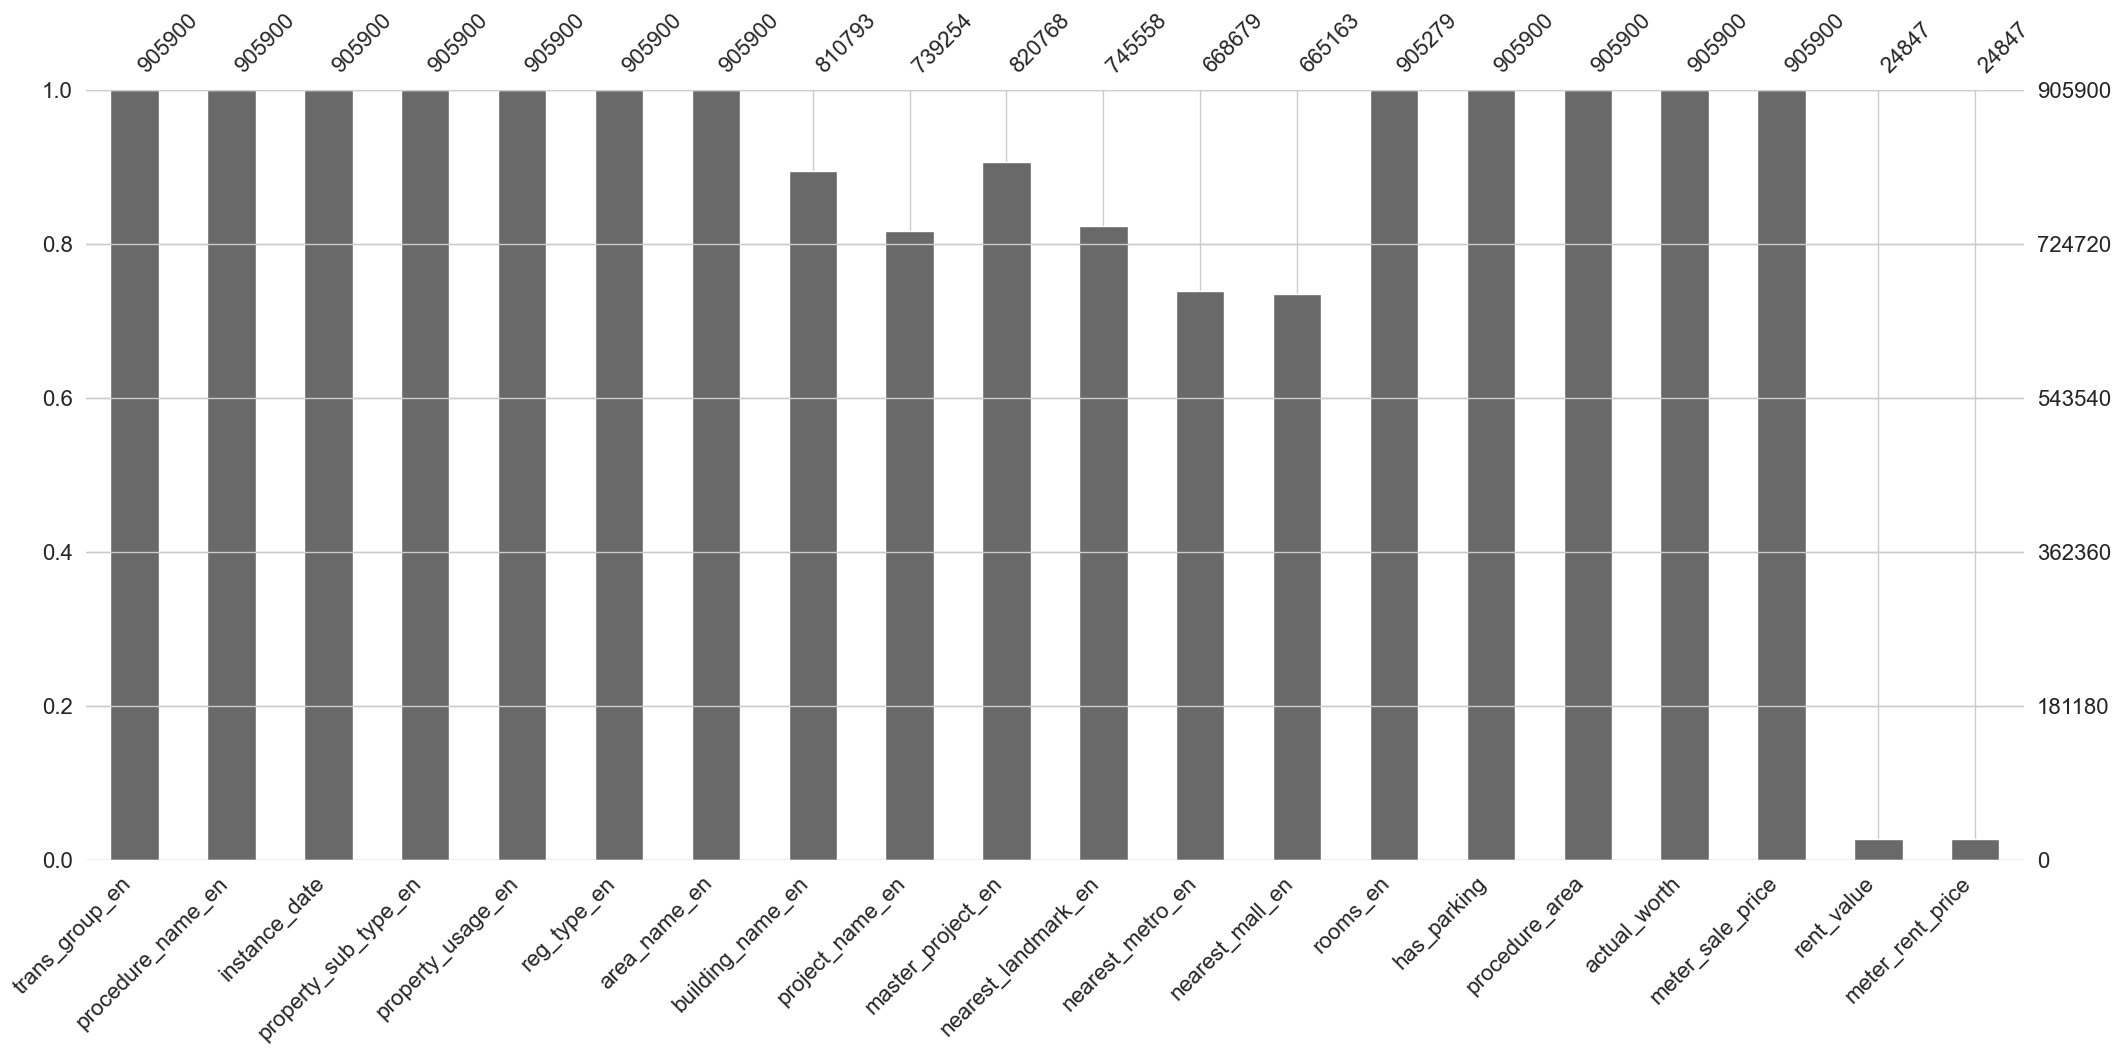

In [606]:
msno.bar(new_data)  # Bar chart visualization to check the number of missing values in each feature

plt.show()

<Axes: >

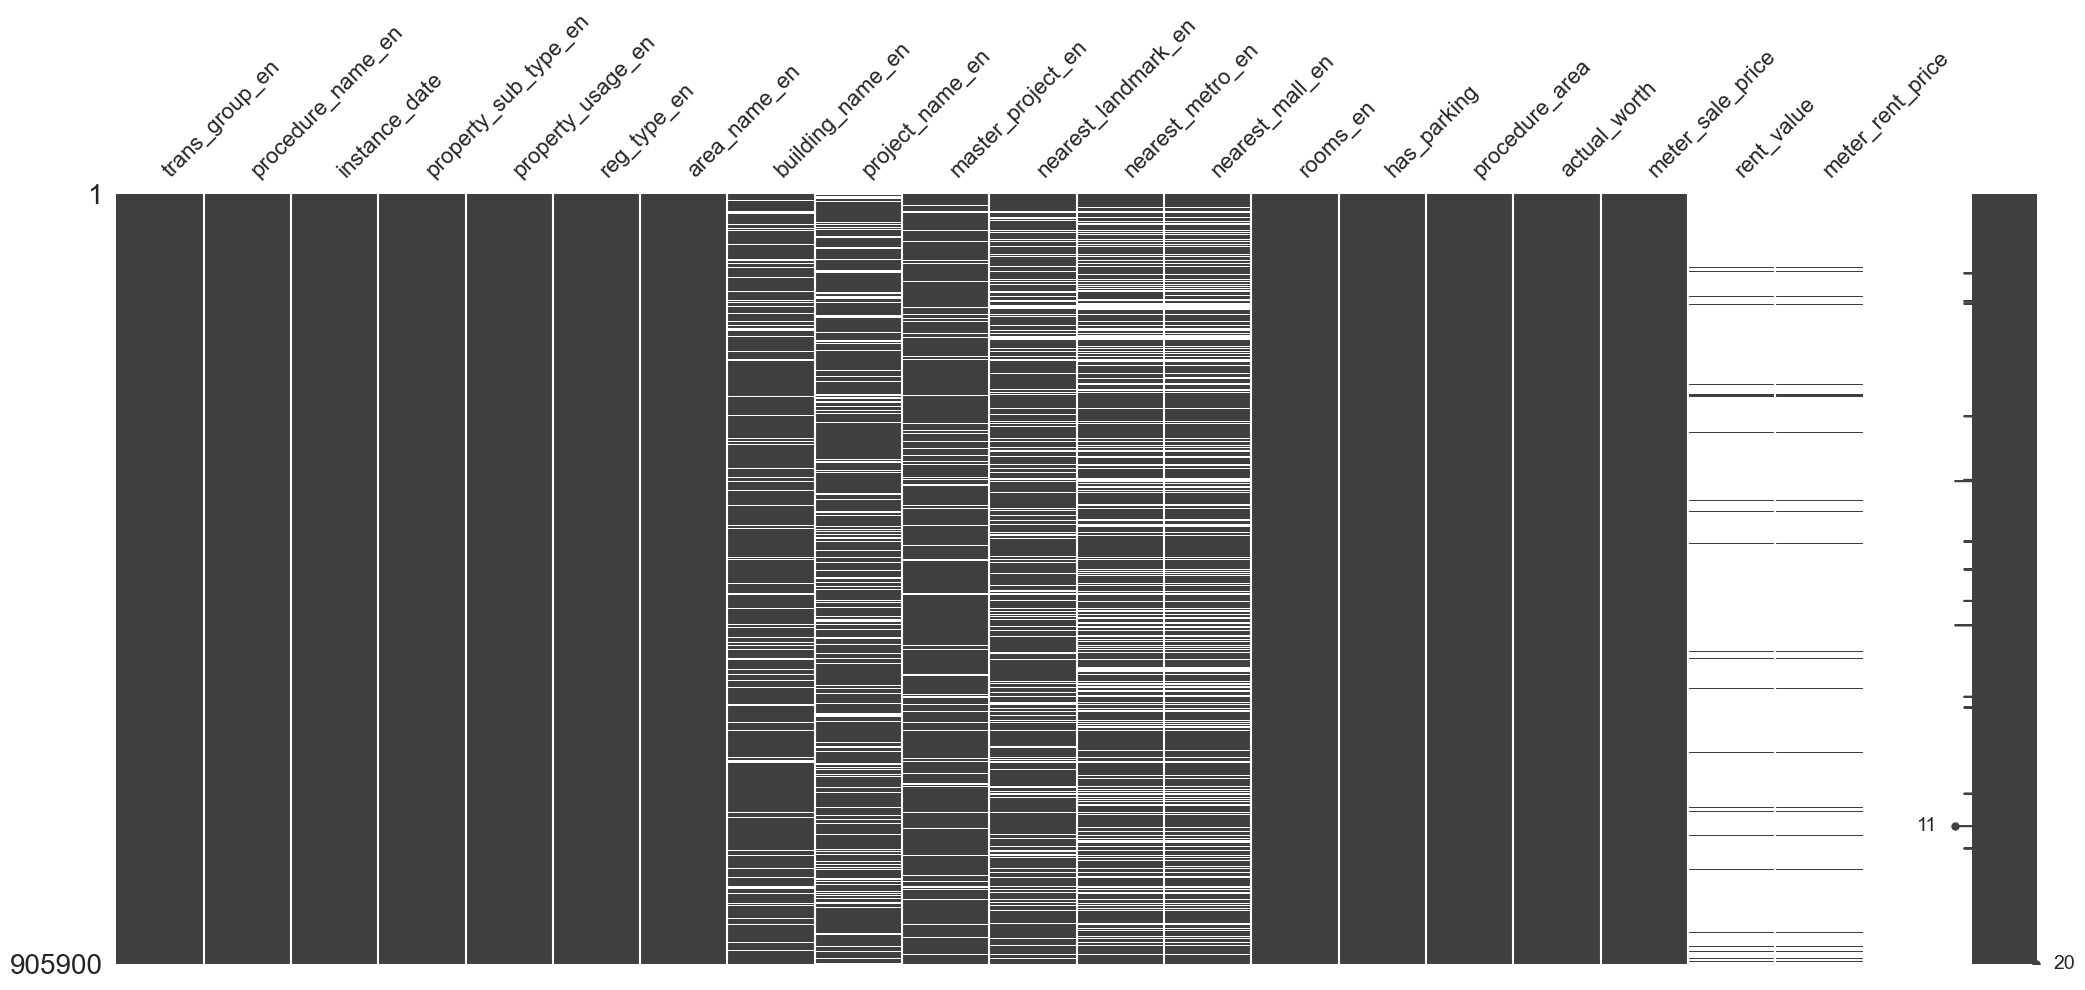

In [607]:
msno.matrix(new_data)

In [608]:
def missing_values_percentage(input_df):
    # Get the total number of rows in the DataFrame
    total_rows = input_df.shape[0]
    
    # Calculate the number of missing values per feature
    missing_values_count = input_df.isnull().sum()
    
    # Calculate the percentage of missing values per feature
    missing_values_percentage = (missing_values_count / total_rows) * 100
    
    # Create a DataFrame to store the results
    missing_df = pd.DataFrame({
        'column_name': missing_values_percentage.index,
        'missing_count': missing_values_count.values,
        'missing_ratio': missing_values_percentage.values
    })
    
    # Filter out features with missing ratio greater than 0%
    missing_df = missing_df[missing_df['missing_ratio'] > 0]
    
    return missing_df

print("Statistics of missing values per feature:")
print(missing_values_percentage(new_data))

Statistics of missing values per feature:
            column_name  missing_count  missing_ratio
7      building_name_en          95107         10.499
8       project_name_en         166646         18.396
9     master_project_en          85132          9.398
10  nearest_landmark_en         160342         17.700
11     nearest_metro_en         237221         26.186
12      nearest_mall_en         240737         26.574
13             rooms_en            621          0.069
18           rent_value         881053         97.257
19     meter_rent_price         881053         97.257


In [609]:
columns_to_drop = [ 'rent_value', # 97% of missing values
                   'meter_rent_price', # 97% of missing values
                   'meter_sale_price', # feature is derived from 'actual_worth', dropping to prevent a target leakage issue  where the model could otherwise “cheat”
                   'building_name_en', # dropped because of too many categories. missing: 87001, Length: 3195
                   'project_name_en', # dropped because of too many categories. missing: 166685, Length: 1544
                ] 

# Reset indices
# After data cleaning the indices refer to  all data (including the removed observations)
data_cleaned = new_data.drop(columns_to_drop, axis=1).reset_index(drop=True)

In [610]:
print(data_cleaned.shape)
data_cleaned.info()

(905900, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905900 entries, 0 to 905899
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   trans_group_en        905900 non-null  object        
 1   procedure_name_en     905900 non-null  object        
 2   instance_date         905900 non-null  datetime64[ns]
 3   property_sub_type_en  905900 non-null  object        
 4   property_usage_en     905900 non-null  object        
 5   reg_type_en           905900 non-null  object        
 6   area_name_en          905900 non-null  object        
 7   master_project_en     820768 non-null  object        
 8   nearest_landmark_en   745558 non-null  object        
 9   nearest_metro_en      668679 non-null  object        
 10  nearest_mall_en       665163 non-null  object        
 11  rooms_en              905279 non-null  object        
 12  has_parking           905900 non-null  int64 

## Feature Engineering

### Preprocess date

In [611]:
# Extract date components
data_cleaned['year'] = data_cleaned['instance_date'].dt.year
data_cleaned['month'] = data_cleaned['instance_date'].dt.month
data_cleaned['day'] = data_cleaned['instance_date'].dt.day

# Optional: Cyclical encoding for month and day
data_cleaned['month_sin'] = np.sin(2 * np.pi * data_cleaned['month'] / 12)
data_cleaned['month_cos'] = np.cos(2 * np.pi * data_cleaned['month'] / 12)
data_cleaned['day_sin'] = np.sin(2 * np.pi * data_cleaned['day'] / 31)
data_cleaned['day_cos'] = np.cos(2 * np.pi * data_cleaned['day'] / 31)

data_cleaned.head(10)

,trans_group_en,procedure_name_en,instance_date,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,procedure_area,actual_worth,year,month,day,month_sin,month_cos,day_sin,day_cos
0,sales,delayed_sell,2024-12-06,flat,residential,existing_properties,al_hebiah_fourth,dubai_sports_city,sports_city_swimming_academy,nakheel_metro_station,marina_mall,studio,1,38.260,500000.000,2024,12,6,-0.000,1.000,0.938,0.347
1,sales,sell,2013-06-27,villa,residential,existing_properties,al_thanyah_third,NaN,sports_city_swimming_academy,nakheel_metro_station,marina_mall,3_bedroom,0,308.980,3150000.000,2013,6,27,0.000,-1.000,-0.725,0.689
2,sales,sell_-_pre_registration,2024-06-27,flat,residential,off-plan_properties,al_jadaf,jaddaf_waterfront,dubai_international_airport,al_jadaf_metro_station,dubai_mall,2_bedroom,1,126.120,2758828.000,2024,6,27,0.000,-1.000,-0.725,0.689
3,sales,sell_-_pre_registration,2025-03-28,flat,residential,off-plan_properties,al_satwa,jumeirah_garden_city,burj_khalifa,emirates_towers_metro_station,dubai_mall,1_bedroom,1,75.490,1450012.000,2025,3,28,1.000,0.000,-0.571,0.821
4,sales,sell,2016-06-07,flat,residential,existing_properties,al_warsan_first,international_city_phase_1,NaN,rashidiya_metro_station,city_centre_mirdif,1_bedroom,1,86.310,495000.000,2016,6,7,0.000,-1.000,0.988,0.151
5,mortgages,lease_to_own_registration,2018-01-17,flat,residential,existing_properties,al_warsan_first,international_city_phase_1,NaN,rashidiya_metro_station,city_centre_mirdif,1_bedroom,1,126.260,637500.000,2018,1,17,0.500,0.866,-0.299,-0.954
6,sales,sell_-_pre_registration,2018-07-18,flat,residential,off-plan_properties,al_safouh_first,sufouh_gardens,burj_al_arab,dubai_internet_city,mall_of_the_emirates,3_bedroom,1,192.020,1600000.000,2018,7,18,-0.500,-0.866,-0.485,-0.874
7,sales,sell,2012-12-31,flat,residential,existing_properties,marsa_dubai,dubai_marina,burj_al_arab,mina_seyahi,marina_mall,1_bedroom,1,74.450,2859516.000,2012,12,31,-0.000,1.000,-0.000,1.000
8,sales,delayed_sell,2012-12-06,flat,residential,existing_properties,marsa_dubai,dubai_marina,burj_al_arab,mina_seyahi,marina_mall,1_bedroom,1,89.140,1165733.000,2012,12,6,-0.000,1.000,0.938,0.347
9,sales,sell,2024-02-07,flat,residential,existing_properties,al_barshaa_south_third,arjan,motor_city,sharaf_dg_metro_station,mall_of_the_emirates,1_bedroom,1,76.350,800000.000,2024,2,7,0.866,0.500,0.988,0.151


In [612]:
data_cleaned = data_cleaned.drop('instance_date', axis=1)
data_cleaned.shape

(905900, 21)

**Transactions by Year**

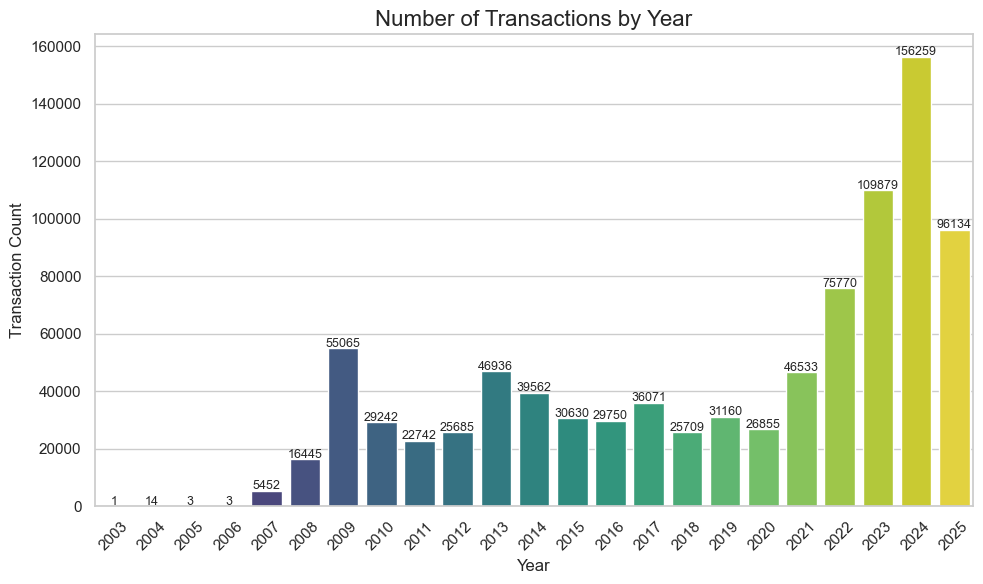

In [613]:
# Set plot style
sns.set_theme(style="whitegrid")

# Count number of transactions per year
year_counts = data_cleaned['year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=year_counts.index, y=year_counts.values, hue=year_counts.index, palette='viridis', legend=False)

# Add bar labels
for i, v in enumerate(year_counts.values):
    ax.text(i, v + 500, str(v), ha='center', fontsize=9)

plt.title('Number of Transactions by Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Perform Imputing for the 'rooms_en' column with the XGBClassifier
Implementing imputation with a predictive model involves training a machine learning model to predict missing values based on other features in the dataset. 

**Plan**:

1. Split the dataset between rows with the column 'rooms_en' filled in, and rows with null values.
2. Train the classification model with the rooms_en as target feature utilising the first dataframe
3. Evaluate the model
4. Use the model trained to predict the missing values from the dataframe with null values
5. Merge the two dataframe into one

**Split the dataset**

In [614]:
# split the dataset between rows with the column rooms_en, and rows with null values.

df_with_rooms = data_cleaned[data_cleaned['rooms_en'].notna()]
print("N. rows with rooms_en not null:", df_with_rooms.shape[0])

df_no_rooms = data_cleaned[data_cleaned['rooms_en'].isna()]
print("N. rows with rooms_en null:", df_no_rooms.shape[0])

N. rows with rooms_en not null: 905279
N. rows with rooms_en null: 621


**Train XGBoost Classifier for 'rooms_en' multiclass prediction**

In [615]:
# Encode target
le = LabelEncoder()
y = le.fit_transform(df_with_rooms["rooms_en"])

# Select features
X = df_with_rooms.drop(['rooms_en','actual_worth'], axis=1)

# Convert object columns to categorical for XGBoost
categorical_cols = X.select_dtypes(include=['object']).columns
X[categorical_cols] = X[categorical_cols].astype("category")

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y  # ensures rare classes appear in test set
)

# Define and train the model
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    enable_categorical=True,
    n_estimators=45,
    max_depth=25,
    n_jobs=-1,
    reg_alpha=2,
    reg_lambda=5
)

model.fit(X_train, Y_train)
feature_cols = X.columns

**Evaluate the model**

In [616]:
# Get full list of class labels from training data
all_classes = np.unique(Y_train)

# Predict classes and probabilities
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

# Evaluate
accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred_test)
logloss_test = log_loss(Y_test, y_pred_proba_test, labels=all_classes)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train, accuracy_test))
print("LOG LOSS: " + str(logloss_test))

ACCURACY: TRAIN=0.9857 TEST=0.9562
LOG LOSS: 0.12619019781540972


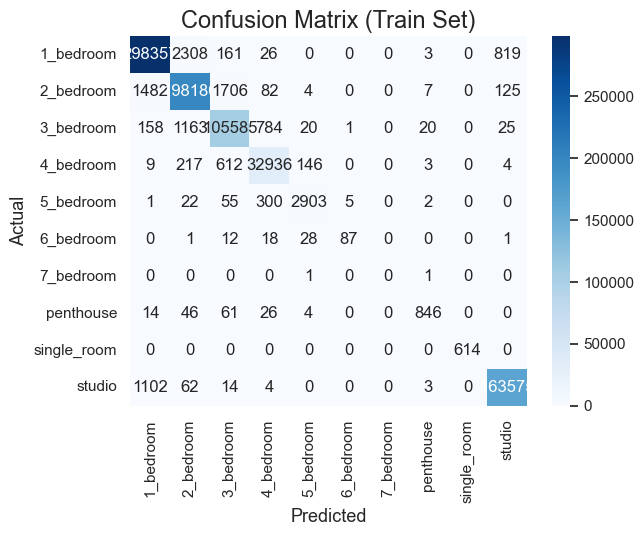

In [617]:
cm = confusion_matrix(Y_train,y_pred_train)
classes=le.classes_
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=classes,
            yticklabels=classes,
            cmap='Blues'
            )
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Predicted',fontsize=13)
plt.title('Confusion Matrix (Train Set)',fontsize=17)
plt.show()


In [618]:
print(classification_report(Y_train,y_pred_train, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    301674
           1       0.98      0.98      0.98    201586
           2       0.98      0.98      0.98    107756
           3       0.96      0.97      0.97     33927
           4       0.93      0.88      0.91      3288
           5       0.94      0.59      0.72       147
           6       0.00      0.00      0.00         2
           7       0.96      0.85      0.90       997
           8       1.00      1.00      1.00       614
           9       0.99      0.99      0.99    164760

    accuracy                           0.99    814751
   macro avg       0.87      0.82      0.84    814751
weighted avg       0.99      0.99      0.99    814751



**Observation**

The model performs exceptionally well for most categories but struggled to generalise with less frequent categories such as 7-bedroom.

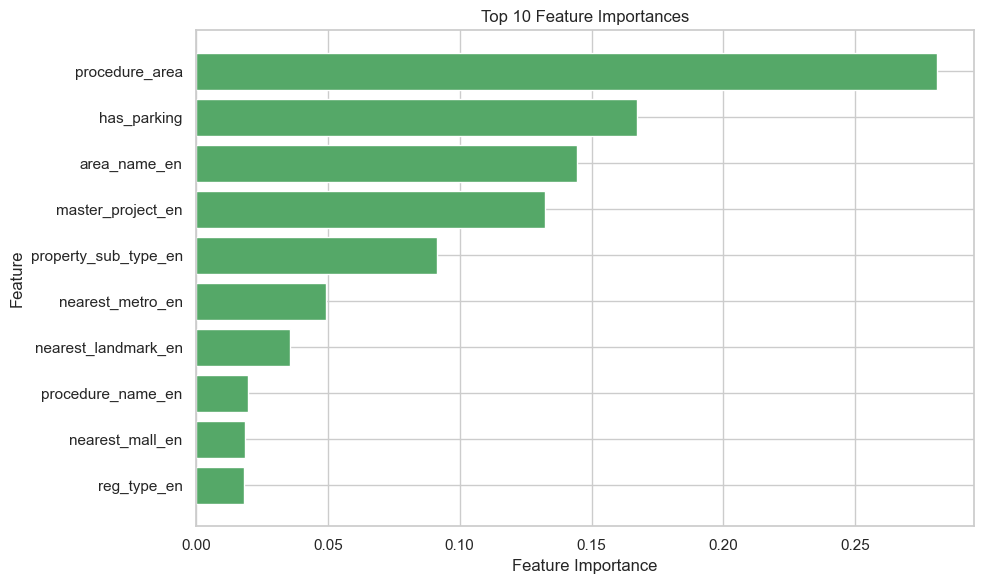

In [619]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Use original feature names from X
feature_names = X.columns.to_numpy()

# Get top 10 features
top_n = 10
top_indices = indices[:top_n]
top_features = feature_names[top_indices]
top_importances = importances[top_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(top_n), top_importances[::-1], color="g", align="center")
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Predict missing values in 'rooms_en'**

In [620]:
# Ensure we keep only the columns used in training
X_pred = df_no_rooms[feature_cols].copy()

# Match categorical dtypes to training
cat_cols = X_pred.select_dtypes(include=["object"]).columns
X_pred[cat_cols] = X_pred[cat_cols].astype("category")

# Predict encoded labels
y_pred_enc = model.predict(X_pred)

# Decode back to original room labels
y_pred_labels = le.inverse_transform(y_pred_enc)

# Drop old rooms_en if present, then insert predicted one
df_no_rooms = df_no_rooms.drop(columns=["rooms_en"], errors="ignore")
df_no_rooms.insert(0, "rooms_en", y_pred_labels)

print(f"Imputed rooms_en for {len(df_no_rooms)} records.")

Imputed rooms_en for 621 records.


**Merge dataframes**

In [621]:
# Merge the dataframes
frames = [df_with_rooms, df_no_rooms]
df_final = pd.concat(frames)
df_final.shape

(905900, 21)

### Convert rooms_en to an integer feature 

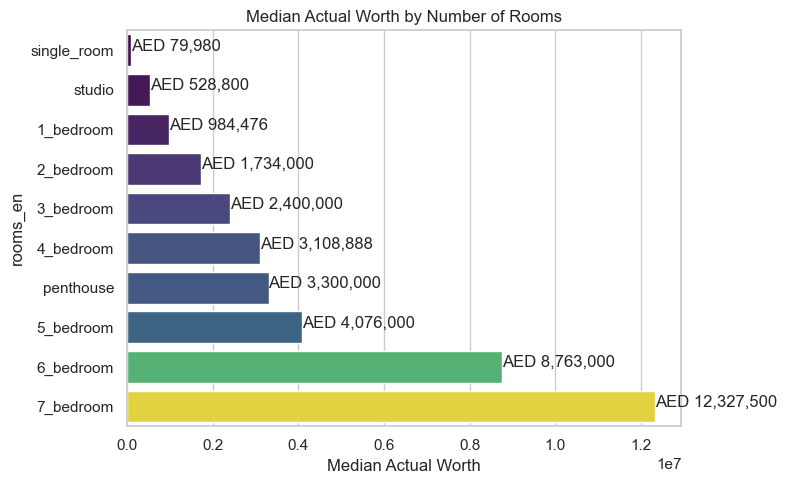

In [622]:
# Group by 'rooms_en' and calculate median 'actual_worth', sorted
median_worth = df_final.groupby('rooms_en')['actual_worth'].median().sort_values()

# Plot horizontal bar chart
plt.figure(figsize=(8, 5))
sns.barplot(
    x=median_worth.values,
    y=median_worth.index,
    hue=median_worth.values,
    palette='viridis', 
    legend=False
)

# Add AED value labels
for i, (value, label) in enumerate(zip(median_worth.values, median_worth.index)):
    plt.text(value, i, f"AED {value:,.0f}", va='baseline')

plt.title('Median Actual Worth by Number of Rooms')
plt.xlabel('Median Actual Worth')
plt.tight_layout()
plt.show()


In [623]:
room_mapping = {
    'single_room': 0,   # treated as smaller than studio
    'studio': 0.5,
    '1_bedroom': 1,
    '2_bedroom': 2,
    '3_bedroom': 3,
    '4_bedroom': 4,
    'penthouse': 4.5,     # between 4 and 5
    '5_bedroom': 5,
    '6_bedroom': 6,
    '7_bedroom': 7,
    '8_bedroom': 8
}


df_final['rooms_en'] = df_final['rooms_en'].map(room_mapping)
df_final = df_final.rename(columns={'rooms_en': 'rooms_count'})


### Derive 'Area per Room' feature

In [624]:
# area_per_room = procedure_area / (number_of_rooms)
df_final['area_per_room'] = df_final.apply(
    lambda row: row['procedure_area'] / row['rooms_count'] if row['rooms_count'] >= 1 else row['procedure_area'],
    axis=1
)
df_final

,trans_group_en,procedure_name_en,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_count,has_parking,procedure_area,actual_worth,year,month,day,month_sin,month_cos,day_sin,day_cos,area_per_room
0,sales,delayed_sell,flat,residential,existing_properties,al_hebiah_fourth,dubai_sports_city,sports_city_swimming_academy,nakheel_metro_station,marina_mall,0.500,1,38.260,500000.000,2024,12,6,-0.000,1.000,0.938,0.347,38.260
1,sales,sell,villa,residential,existing_properties,al_thanyah_third,NaN,sports_city_swimming_academy,nakheel_metro_station,marina_mall,3.000,0,308.980,3150000.000,2013,6,27,0.000,-1.000,-0.725,0.689,102.993
2,sales,sell_-_pre_registration,flat,residential,off-plan_properties,al_jadaf,jaddaf_waterfront,dubai_international_airport,al_jadaf_metro_station,dubai_mall,2.000,1,126.120,2758828.000,2024,6,27,0.000,-1.000,-0.725,0.689,63.060
3,sales,sell_-_pre_registration,flat,residential,off-plan_properties,al_satwa,jumeirah_garden_city,burj_khalifa,emirates_towers_metro_station,dubai_mall,1.000,1,75.490,1450012.000,2025,3,28,1.000,0.000,-0.571,0.821,75.490
4,sales,sell,flat,residential,existing_properties,al_warsan_first,international_city_phase_1,NaN,rashidiya_metro_station,city_centre_mirdif,1.000,1,86.310,495000.000,2016,6,7,0.000,-1.000,0.988,0.151,86.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900177,sales,sell_-_pre_registration,flat,residential,off-plan_properties,al_wasl,city_walk,NaN,NaN,NaN,2.000,1,119.220,4222000.000,2024,2,15,0.866,0.500,0.101,-0.995,59.610
903149,sales,sell_-_pre_registration,villa,residential,off-plan_properties,saih_shuaib_2,NaN,al_makhtoum_international_airport,uae_exchange_metro_station,NaN,3.000,0,200.700,1708181.000,2010,1,11,0.500,0.866,0.791,-0.612,66.900
904549,sales,sell_-_pre_registration,flat,residential,off-plan_properties,al_wasl,city_walk,NaN,NaN,NaN,2.000,1,119.220,4243000.000,2024,1,4,0.500,0.866,0.725,0.689,59.610
904762,sales,sell_-_pre_registration,flat,residential,off-plan_properties,al_wasl,city_walk,NaN,NaN,NaN,3.000,1,218.270,7418000.000,2024,2,5,0.866,0.500,0.849,0.529,72.757


### Encoding Categorical Variables for Modeling  

In [627]:
categorical_cols = df_final.select_dtypes(include=['object']).columns
df_final[categorical_cols] = df_final[categorical_cols].astype("category")
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905900 entries, 0 to 905717
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   trans_group_en        905900 non-null  category
 1   procedure_name_en     905900 non-null  category
 2   property_sub_type_en  905900 non-null  category
 3   property_usage_en     905900 non-null  category
 4   reg_type_en           905900 non-null  category
 5   area_name_en          905900 non-null  category
 6   master_project_en     820768 non-null  category
 7   nearest_landmark_en   745558 non-null  category
 8   nearest_metro_en      668679 non-null  category
 9   nearest_mall_en       665163 non-null  category
 10  rooms_count           905900 non-null  float64 
 11  has_parking           905900 non-null  int64   
 12  procedure_area        905900 non-null  float64 
 13  actual_worth          905900 non-null  float64 
 14  year                  905900 non-null  in

### Note on Missing Values in Categorical Features

Missing values (`NaN`) in categorical columns are **not imputed manually**, because XGBoost can **natively handle missing values**. During training, XGBoost **learns the optimal path** for missing categories in decision trees, which often yields better performance than manually imputing with placeholder values like `"unknown"` or `"none"`.

This approach avoids introducing artificial categories and lets the model determine the most informative split behavior for missing data.


We will set `penthouse` to **5** because its median price (3.25M) is closest to that of a **5-bedroom** unit (4.08M) and slightly above a **4-bedroom** (2.72M). This suggests penthouses are most similar in value and likely size to high-bedroom properties, making **5** a reasonable numeric representation for modeling.

## Organize Columns and Export Clean Data

In [628]:
# Rearrange columns so that the target variable is set as the first column and is followed by feature columns
# This is because sagemaker built-in algorithm expects the data in this format

df_final.insert(0, 'actual_worth', df_final.pop('actual_worth'))

In [629]:
df_final.head()

,actual_worth,trans_group_en,procedure_name_en,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_count,has_parking,procedure_area,year,month,day,month_sin,month_cos,day_sin,day_cos,area_per_room
0,500000.000,sales,delayed_sell,flat,residential,existing_properties,al_hebiah_fourth,dubai_sports_city,sports_city_swimming_academy,nakheel_metro_station,marina_mall,0.500,1,38.260,2024,12,6,-0.000,1.000,0.938,0.347,38.260
1,3150000.000,sales,sell,villa,residential,existing_properties,al_thanyah_third,NaN,sports_city_swimming_academy,nakheel_metro_station,marina_mall,3.000,0,308.980,2013,6,27,0.000,-1.000,-0.725,0.689,102.993
2,2758828.000,sales,sell_-_pre_registration,flat,residential,off-plan_properties,al_jadaf,jaddaf_waterfront,dubai_international_airport,al_jadaf_metro_station,dubai_mall,2.000,1,126.120,2024,6,27,0.000,-1.000,-0.725,0.689,63.060
3,1450012.000,sales,sell_-_pre_registration,flat,residential,off-plan_properties,al_satwa,jumeirah_garden_city,burj_khalifa,emirates_towers_metro_station,dubai_mall,1.000,1,75.490,2025,3,28,1.000,0.000,-0.571,0.821,75.490
4,495000.000,sales,sell,flat,residential,existing_properties,al_warsan_first,international_city_phase_1,NaN,rashidiya_metro_station,city_centre_mirdif,1.000,1,86.310,2016,6,7,0.000,-1.000,0.988,0.151,86.310


In [630]:
columns = df_final.columns.tolist()
columns

['actual_worth',
 'trans_group_en',
 'procedure_name_en',
 'property_sub_type_en',
 'property_usage_en',
 'reg_type_en',
 'area_name_en',
 'master_project_en',
 'nearest_landmark_en',
 'nearest_metro_en',
 'nearest_mall_en',
 'rooms_count',
 'has_parking',
 'procedure_area',
 'year',
 'month',
 'day',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'area_per_room']

In [631]:
# Write Column List to the file
with open('dld_train_column_list.txt','w') as f:
    f.write(','.join(columns))

In [632]:
# Save all data
df_final.to_csv('data/final_dataset.csv', index=False, columns=columns)